# Pipeline for the anomaly detection on the SKAB using MSCRED

In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../utils')
from evaluating import evaluating_change_point

## Data loading

In [2]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

## Data description and visualization

In [4]:
# dataset characteristics printing
print(f'A number of datasets in the SkAB v1.0: {len(list_of_df)}\n')
print(f'Shape of the random dataset: {list_of_df[0].shape}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'A number of changepoints in the SkAB v1.0: {n_cp}\n')
print(f'A number of outliers in the SkAB v1.0: {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head())

A number of datasets in the SkAB v1.0: 34

Shape of the random dataset: (665, 10)

A number of changepoints in the SkAB v1.0: 130

A number of outliers in the SkAB v1.0: 13241

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 16:28:16,0.080968,0.132892,2.078540,0.054711,88.8333,22.0874,248.524,75.0000,0.0,0.0
2020-03-01 16:28:17,0.080721,0.137438,0.983799,0.710565,88.9111,22.0892,226.593,75.9813,0.0,0.0
2020-03-01 16:28:18,0.081400,0.128858,1.666630,0.054711,88.8676,22.0930,216.814,75.0000,0.0,0.0
2020-03-01 16:28:19,0.080755,0.135728,1.090530,0.382638,88.8907,22.0862,230.363,75.0189,0.0,0.0
2020-03-01 16:28:20,0.080394,0.132174,1.199950,0.382638,88.9437,22.0903,251.789,75.9813,0.0,0.0


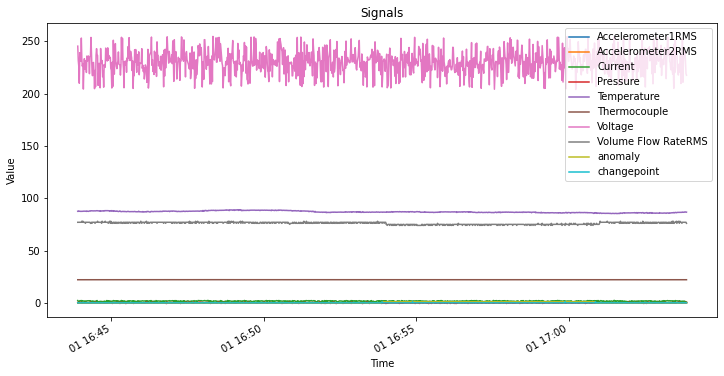

In [5]:
# random dataset visualizing
list_of_df[1].plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

## Labels

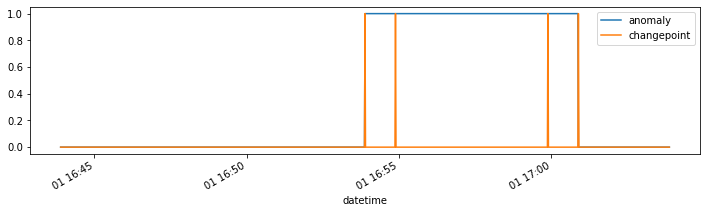

In [6]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[1].anomaly.plot(figsize=(12,3))
list_of_df[1].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [7]:
import numpy as np
import pandas as pd
import os, sys
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv1D, ConvLSTM2D, Conv2DTranspose, TimeDistributed, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorboard.plugins.hparams import api as hp

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [9]:
# Function for repeatability
def Random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

Random(10)

### Training once in the beginning

In [10]:
def create_dataset(df, win_size, gap_time, step_max):

    data = np.array(df, dtype=np.float64)
    sensor_n = data.shape[1]
    data_all = []
    scale_n = len(win_size)
    # min-max normalization
    data = MinMaxScaler().fit_transform(data).T

    for win in win_size:
        matrix_all = []
        print(f"generating signature with window {win} ...")
        for t in range(win_size[-1], len(df), gap_time):
            matrix_t = np.zeros((sensor_n, sensor_n))
            for i in range(sensor_n):
                for j in range(i, sensor_n):
                    matrix_t[i][j] = np.inner(data[i, t - win:t], data[j, t - win:t])/(win) # rescale by win
                    matrix_t[j][i] = matrix_t[i][j]
            matrix_all.append(matrix_t)
        data_all.append(matrix_all)

    data_all = np.transpose(data_all, (1,2,3,0))

    print (f"create dataset ...")

    dataset = data_all[:step_max]
    for i in range(step_max+1, len(data_all)+1):
        dataset = np.append(dataset, data_all[i-step_max:i], axis=0)

    return dataset.reshape([-1, step_max, sensor_n, sensor_n, scale_n])
    
def net(sensor_n, scale_n, step_max):

    input_size = (step_max, sensor_n, sensor_n, scale_n)
    inputs = Input(input_size)#, batch_size=batch_size)

    if sensor_n % 8 != 0:
        sensor_n_pad = (sensor_n // 8) * 8 + 8
    else:
        sensor_n_pad = sensor_n

    paddings = tf.constant([[0, 0], [0, 0], [0, sensor_n_pad-sensor_n], 
                            [0, sensor_n_pad-sensor_n], [0, 0]])
    inputs_pad = tf.pad(inputs, paddings)

    def attention(outputs, koef):
        attention_w = []
        for k in range(step_max):
            attention_w.append(tf.reduce_sum(tf.multiply(outputs[:,k], outputs[:,-1]), axis=(1,2,3))/step_max)
        attention_w = tf.reshape(tf.nn.softmax(tf.stack(attention_w, axis=1)), [-1, 1, step_max])
        outputs = tf.reshape(outputs, [-1, step_max, tf.reduce_prod(outputs.shape.as_list()[2:])])
        outputs = tf.matmul(attention_w, outputs)
        outputs = tf.reshape(outputs, 
                             [-1, math.ceil(sensor_n_pad/koef), math.ceil(sensor_n_pad/koef), 32*koef])
        return outputs

    # encoder
    conv1 = TimeDistributed(Conv2D(filters = 32, kernel_size = 3, strides = 1, 
                   kernel_initializer='glorot_uniform', padding='same', 
                   activation='selu', name = 'conv1'))(inputs_pad)

    conv2 = TimeDistributed(Conv2D(filters = 64, kernel_size = 3, strides = 2, 
                   kernel_initializer='glorot_uniform', padding='same', 
                   activation='selu', name = 'conv2'))(conv1)

    conv3 = TimeDistributed(Conv2D(filters = 128, kernel_size = 2, strides = 2, 
                   kernel_initializer='glorot_uniform', padding='same', 
                   activation='selu', name = 'conv3'))(conv2)

    conv4 = TimeDistributed(Conv2D(filters = 256, kernel_size = 2, strides = 2, 
                   kernel_initializer='glorot_uniform', padding='same', 
                   activation='selu', name = 'conv4'))(conv3)

    # LSTM attention
    convLSTM1 = ConvLSTM2D(filters = 32, kernel_size = 2, padding = 'same',
                           return_sequences = True, name="convLSTM1")(conv1)
    convLSTM1_out = attention(convLSTM1, 1)

    convLSTM2 = ConvLSTM2D(filters = 64, kernel_size = 2, padding = 'same',
                           return_sequences = True, name="convLSTM2")(conv2)
    convLSTM2_out = attention(convLSTM2, 2)

    convLSTM3 = ConvLSTM2D(filters = 128, kernel_size = 2, padding = 'same',
                           return_sequences = True, name="convLSTM3")(conv3)
    convLSTM3_out = attention(convLSTM3, 4)

    convLSTM4 = ConvLSTM2D(filters = 256, kernel_size = 2, padding = 'same',
                           return_sequences = True, name="convLSTM4")(conv4)
    convLSTM4_out = attention(convLSTM4, 8)

    # decoder 

    deconv4 = Conv2DTranspose(filters = 128, kernel_size = 2, strides = 2, 
                              kernel_initializer='glorot_uniform', padding = 'same', 
                              activation='selu', name = 'deconv4')(convLSTM4_out)
    deconv4_out = tf.concat([deconv4, convLSTM3_out], axis = 3, name = 'concat3')

    deconv3 = Conv2DTranspose(filters = 64, kernel_size = 2, strides = 2,
                              kernel_initializer='glorot_uniform', padding = 'same', 
                              activation='selu', name = 'deconv3')(deconv4_out)
    deconv3_out = tf.concat([deconv3, convLSTM2_out], axis = 3, name = 'concat2')

    deconv2 = Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2, 
                              kernel_initializer='glorot_uniform', padding = 'same', 
                              activation='selu', name = 'deconv2')(deconv3_out)
    deconv2_out = tf.concat([deconv2, convLSTM1_out], axis = 3, name = 'concat1')

    deconv1 = Conv2DTranspose(filters = scale_n, kernel_size = 3, strides = 1, 
                              kernel_initializer='glorot_uniform', padding = 'same', 
                              activation='selu', name = 'deconv1')(deconv2_out)

    model = Model(inputs = inputs, outputs = deconv1[:, :sensor_n, :sensor_n, :])

    return model

In [11]:
df = list_of_df[1]
df = df.drop(['anomaly','changepoint'], axis=1)

step_max = 10              # maximum step in ConvLSTM
gap_time = 1             # gap time between each segment
win_size = [50, 60]    # window size of each segment
scale_n = len(win_size)
sensor_n = df.shape[1]

In [12]:
%%time
dataset = create_dataset(df, win_size, gap_time, step_max)
train_stop = (400 - win_size[-1])//gap_time - step_max
print(train_stop)
X_train = dataset[:train_stop]
Y_train = dataset[:train_stop, -1]
X_test = dataset[train_stop:]
Y_test = dataset[train_stop:, -1]

generating signature with window 50 ...
generating signature with window 60 ...
create dataset ...
330
Wall time: 2.25 s


In [13]:
model=net(sensor_n=sensor_n, scale_n=scale_n, step_max=step_max)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 8, 8, 2) 0                                            
__________________________________________________________________________________________________
tf.compat.v1.pad (TFOpLambda)   (None, 10, 8, 8, 2)  0           input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 10, 8, 8, 32) 608         tf.compat.v1.pad[0][0]           
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 10, 4, 4, 64) 18496       time_distributed[0][0]           
______________________________________________________________________________________________

In [14]:
def loss_fn(y_true, y_pred):
    
    return tf.reduce_mean(tf.square(y_true - y_pred))

model.compile(optimizer = Adam(learning_rate=1e-3),
              loss = loss_fn,
              )
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, 
                              patience=6, min_lr=0.000001, 
                              verbose = 1)

In [15]:
%%time
history = model.fit(X_train, Y_train, batch_size=50, epochs=10,
                    validation_data = (X_test, Y_test),
                    callbacks=reduce_lr)

Epoch 1/10
7/7 [==============================] - 24s 1s/step - loss: 0.0806 - val_loss: 0.0084
Epoch 2/10
7/7 [==============================] - 5s 700ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 3/10
7/7 [==============================] - 5s 674ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 4/10
7/7 [==============================] - 4s 657ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 5/10
7/7 [==============================] - 5s 703ms/step - loss: 8.9626e-04 - val_loss: 0.0030
Epoch 6/10
7/7 [==============================] - 5s 679ms/step - loss: 5.3636e-04 - val_loss: 0.0027
Epoch 7/10
7/7 [==============================] - 5s 659ms/step - loss: 3.9166e-04 - val_loss: 0.0024
Epoch 8/10
7/7 [==============================] - 5s 755ms/step - loss: 3.1187e-04 - val_loss: 0.0024
Epoch 9/10
7/7 [==============================] - 5s 721ms/step - loss: 2.7175e-04 - val_loss: 0.0022
Epoch 10/10
7/7 [==============================] - 5s 686ms/step - loss: 2.2599e-04 - val_loss: 0.00

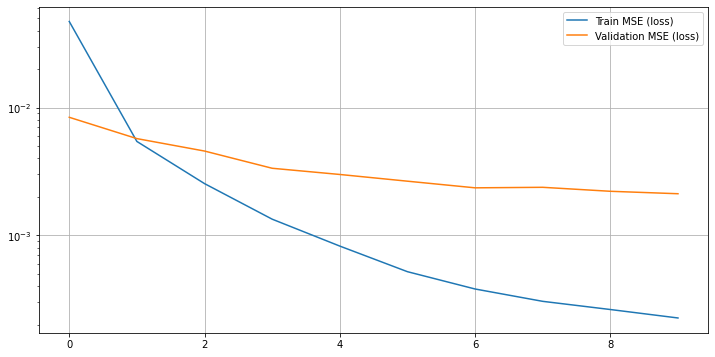

In [16]:
fig, (ax_loss) = plt.subplots(1, 1, figsize=(12,6))
ax_loss.semilogy(history.epoch, history.history["loss"], label="Train MSE (loss)")
ax_loss.semilogy(history.epoch, history.history["val_loss"], label="Validation MSE (loss)")
ax_loss.grid()
ax_loss.legend()
plt.show()

In [17]:
Y_pred = model.predict(dataset)

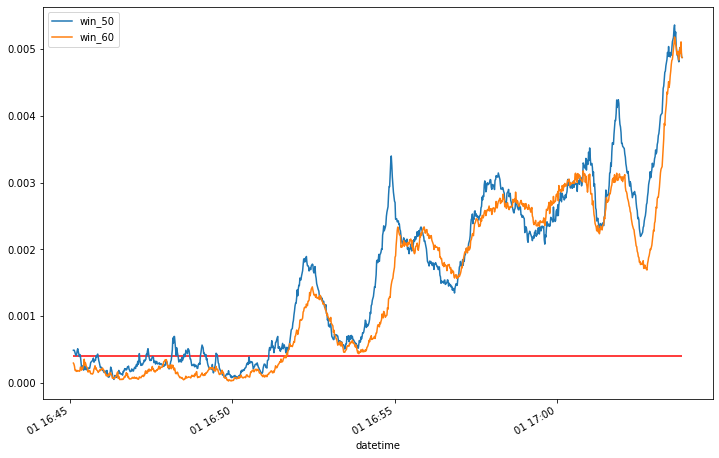

In [18]:
resid_mat = dataset[:, -1] - Y_pred
mse = np.mean(np.square(resid_mat), axis=(1,2))
t = df.index[win_size[-1]::gap_time][step_max-1:]
mse_df = pd.DataFrame(mse, 
                      index=t,
                      columns=[f'win_{i}' for i in win_size])

r = mse_df.mean(axis=1)
UCL = r[:train_stop].quantile(0.99)
prediction = pd.Series((r>3/2*UCL).astype(int).values, 
                       t).fillna(0)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.hlines(UCL, t[0], t[-1], 'r')
mse_df.plot(ax=ax);

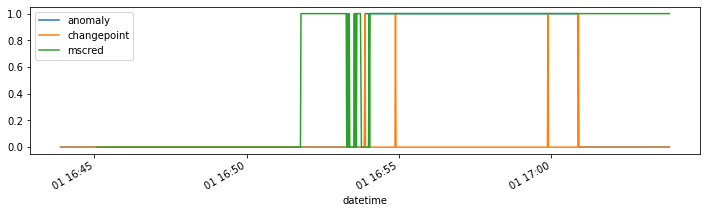

In [19]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[1].anomaly.plot(figsize=(12,3))
list_of_df[1].changepoint.plot()
# plt.plot(t, r, label = 'mscred')
plt.plot(t, prediction, label = 'mscred')
plt.legend()
plt.show()

### Training in the beginning of each dataset

----------------------dataset №1--------------------------------
generating signature with window 60 ...
create dataset ...
Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function loss_fn at 0x000001C59058D310>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source c

<timed exec>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


----------------------dataset №22--------------------------------
generating signature with window 60 ...
create dataset ...
Epoch 1/25
5/5 [==============================] - 19s 1s/step - loss: 0.0992 - val_loss: 0.0188
Epoch 2/25
5/5 [==============================] - 3s 693ms/step - loss: 0.0094 - val_loss: 0.0111
Epoch 3/25
5/5 [==============================] - 4s 742ms/step - loss: 0.0043 - val_loss: 0.0087
Epoch 4/25
5/5 [==============================] - 3s 694ms/step - loss: 0.0021 - val_loss: 0.0073
Epoch 5/25
5/5 [==============================] - 4s 790ms/step - loss: 0.0013 - val_loss: 0.0064
Epoch 6/25
5/5 [==============================] - 3s 676ms/step - loss: 0.0011 - val_loss: 0.0059
Epoch 7/25
5/5 [==============================] - 4s 780ms/step - loss: 7.7159e-04 - val_loss: 0.0055
Epoch 8/25
5/5 [==============================] - 3s 703ms/step - loss: 5.6354e-04 - val_loss: 0.0050
Epoch 9/25
5/5 [==============================] - 3s 713ms/step - loss: 4.6881e-04 - 

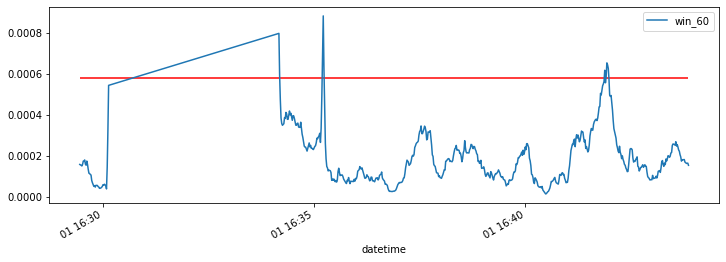

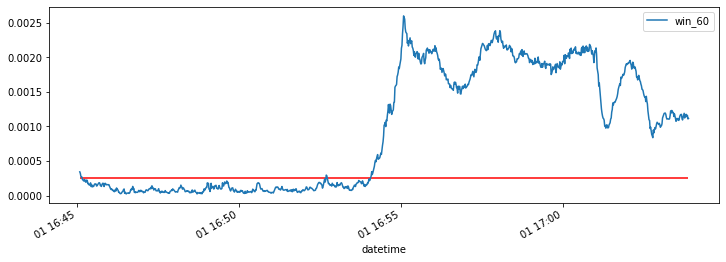

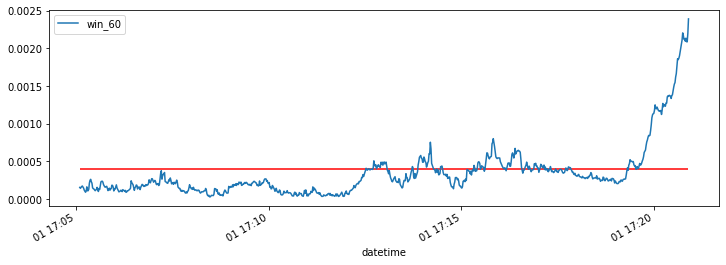

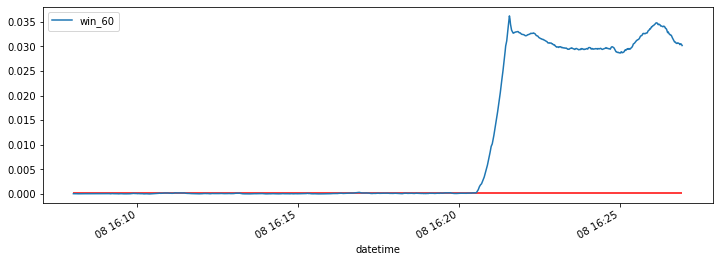

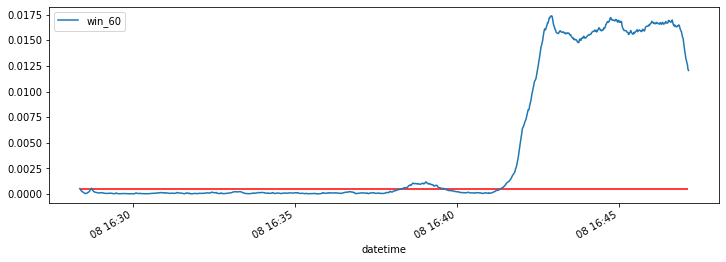

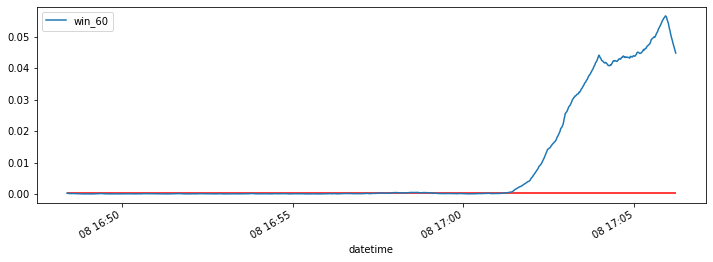

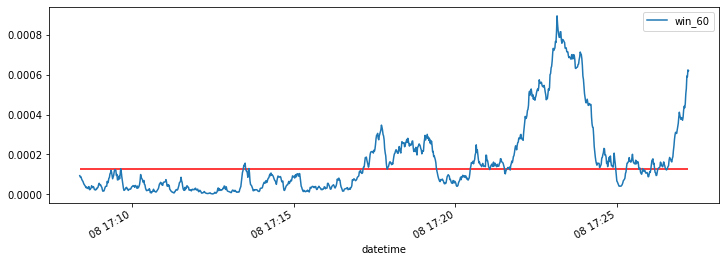

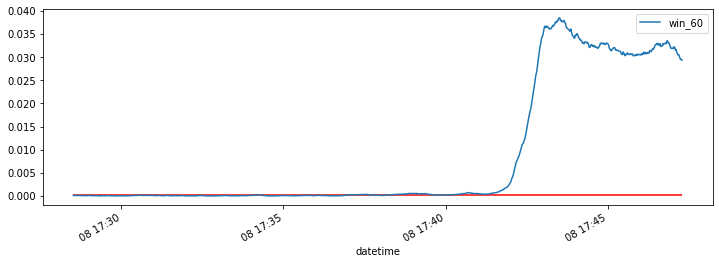

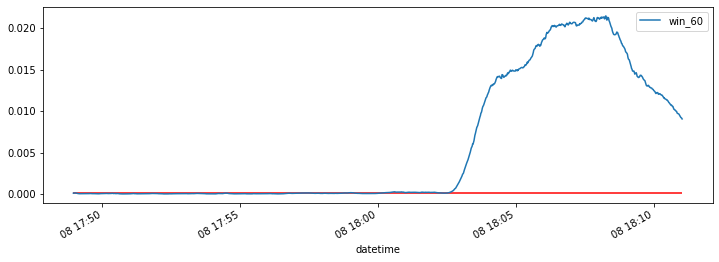

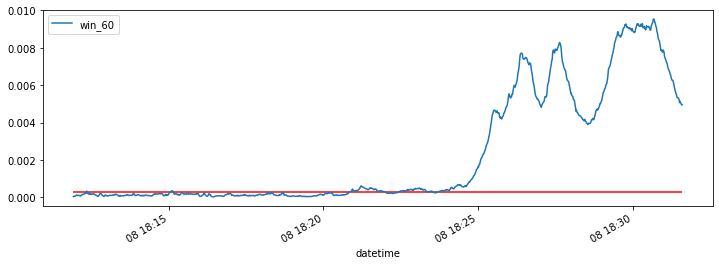

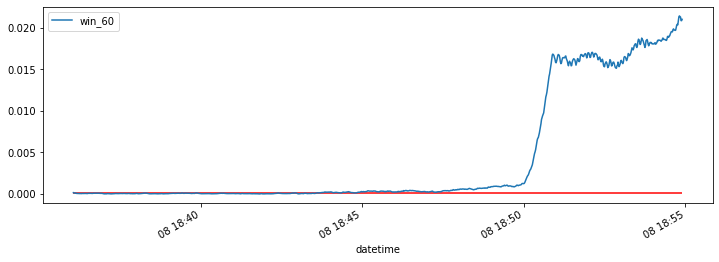

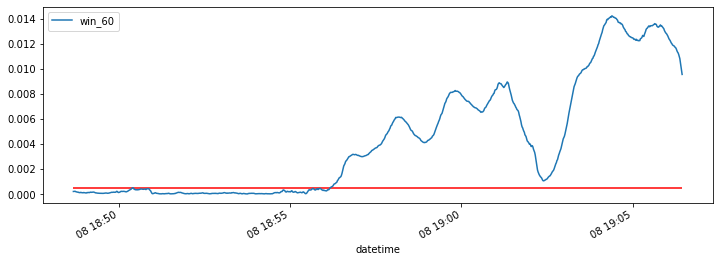

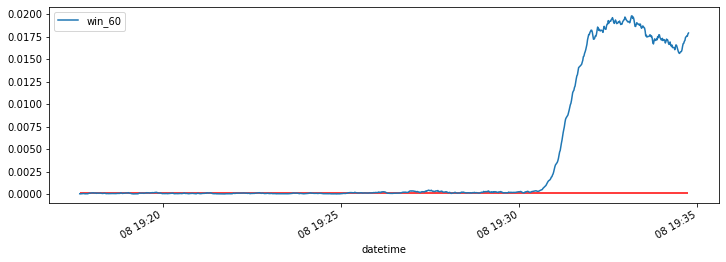

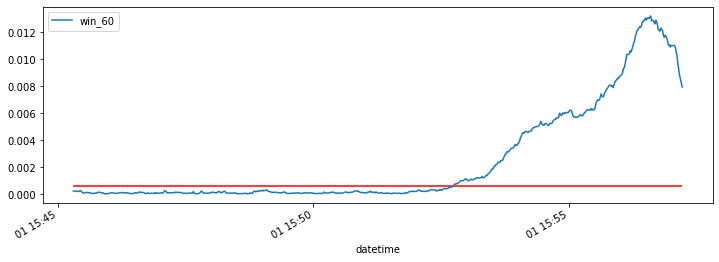

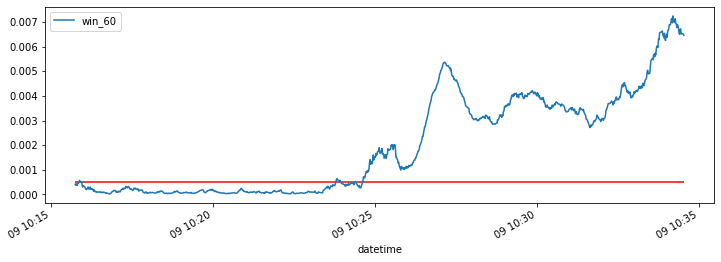

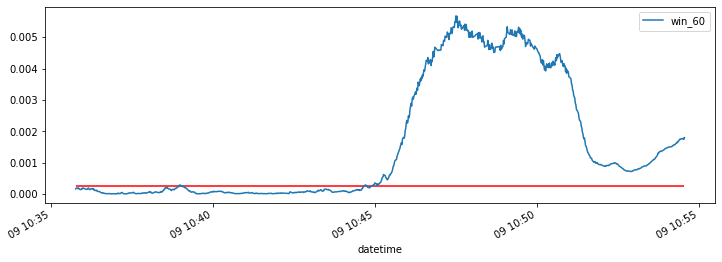

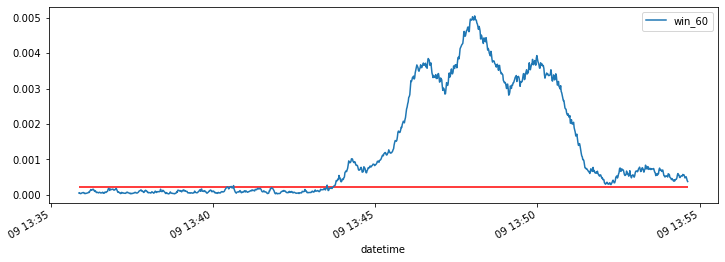

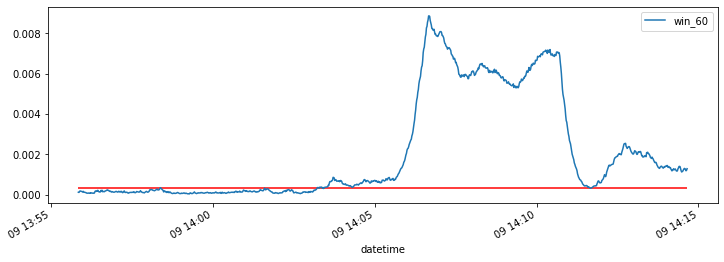

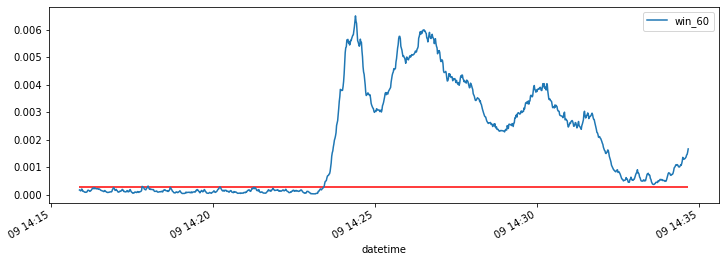

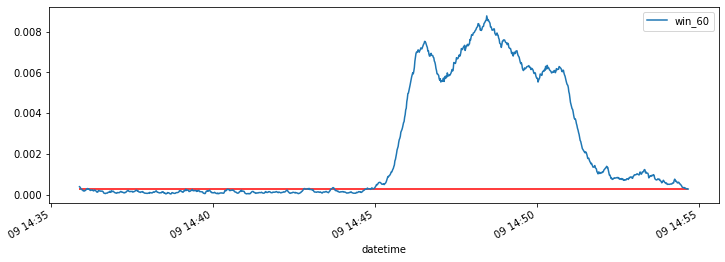

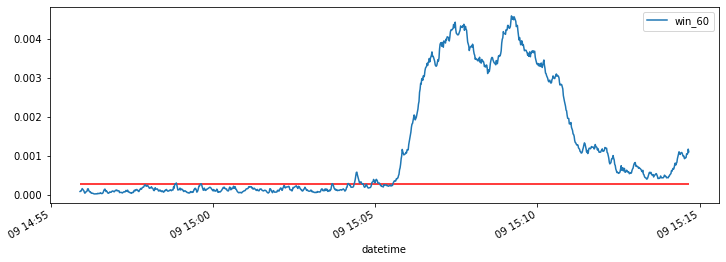

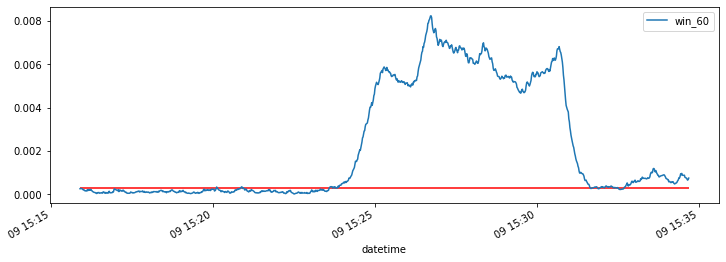

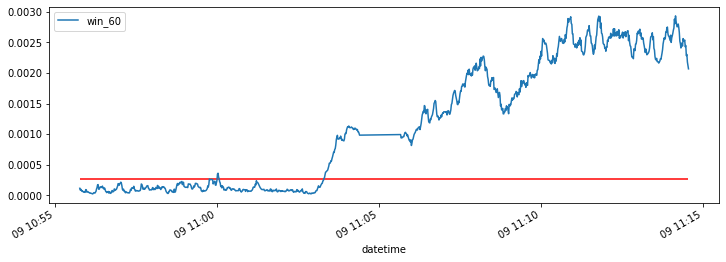

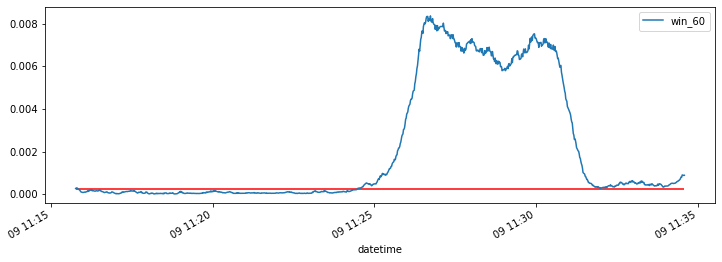

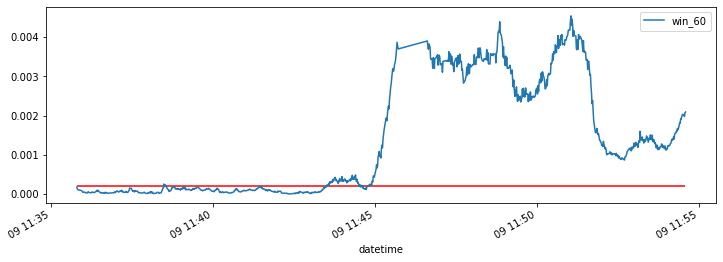

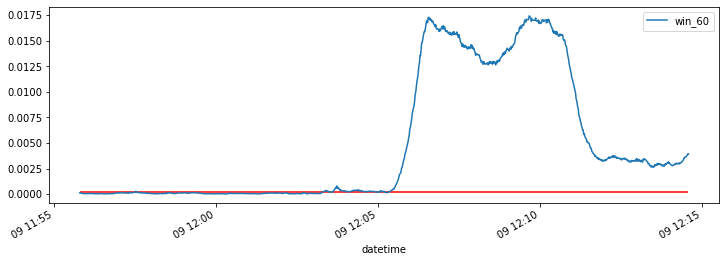

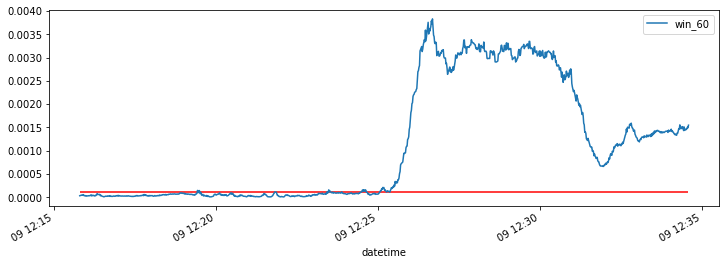

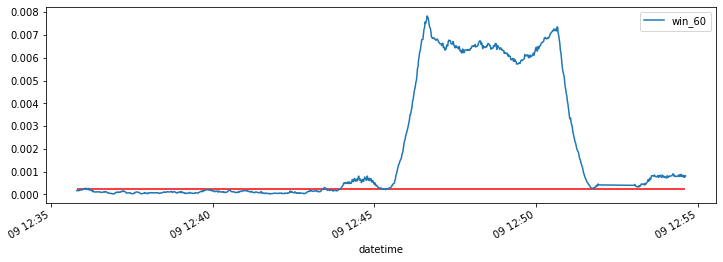

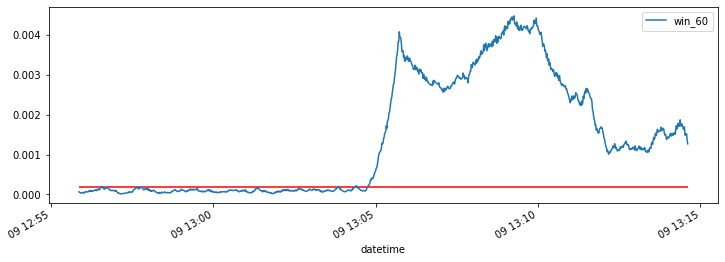

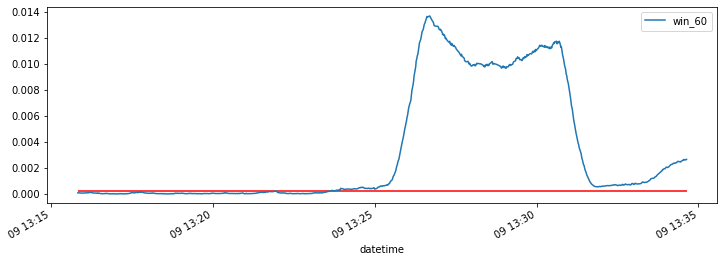

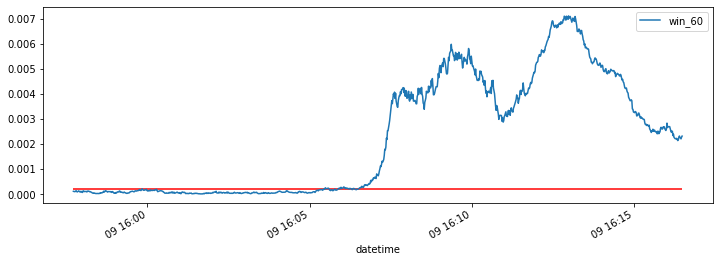

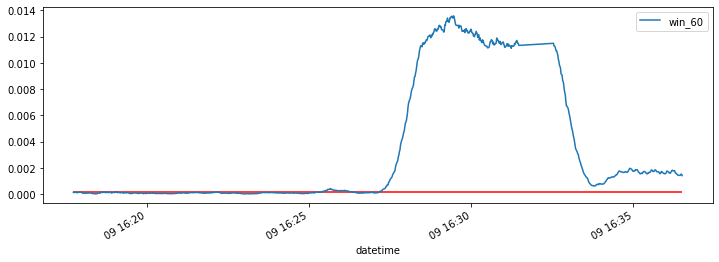

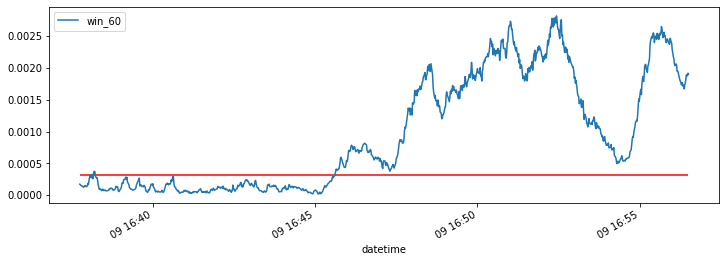

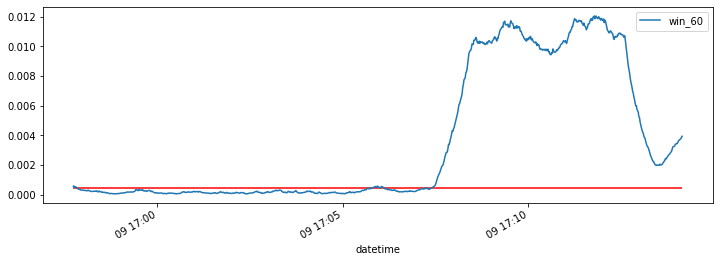

In [27]:
%%time
step_max = 10              # maximum step in ConvLSTM
gap_time = 1               # gap time between each segment
win_size = [60]            # window size of each segment
scale_n = len(win_size)

def loss_fn(y_true, y_pred):
    
    return tf.reduce_mean(tf.square(y_true - y_pred))


# inference
predicted_outlier, predicted_cp = [], []
x = 0 
for df in list_of_df:
    
    x += 1
    print(f'----------------------dataset №{x}--------------------------------')
    df = df.drop(['anomaly','changepoint'], axis=1)
    sensor_n = df.shape[1]
    dataset = create_dataset(df, win_size, gap_time, step_max)
    train_stop = (500 - win_size[-1])//gap_time - step_max
    
    X_train = dataset[:train_stop]
    Y_train = dataset[:train_stop, -1]
    X_test = dataset[train_stop:]
    Y_test = dataset[train_stop:, -1]
    
    model=net(sensor_n=sensor_n, scale_n=scale_n, step_max=step_max)
    
    model.compile(optimizer = Adam(learning_rate=1e-3),
                  loss = loss_fn,
                  )
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, 
                                  patience=6, min_lr=0.000001, 
                                  verbose = 1)
    history = model.fit(X_train, Y_train, batch_size=100, epochs=25,
                    validation_data = (X_test, Y_test),
                    callbacks=reduce_lr)
    
    # results predicting
    Y_pred = model.predict(dataset)
    resid_mat = dataset[:, -1] - Y_pred
    mse = np.mean(np.square(resid_mat), axis=(1,2))
    t = df.index[win_size[-1]::gap_time][step_max-1:]
    mse_df = pd.DataFrame(mse, 
                          index=t,
                          columns=[f'win_{i}' for i in win_size])
    
    residuals = mse_df.mean(axis=1)
    UCL = residuals[:train_stop].quantile(0.99)
    prediction = pd.Series((residuals>3/2*UCL).astype(int).values, 
                           t).fillna(0)
    
    # plot 
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    ax.hlines(UCL, t[0], t[-1], 'r')
    mse_df.plot(ax=ax)
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

### Results

<ipython-input-28-3ee91e65b978>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,3))


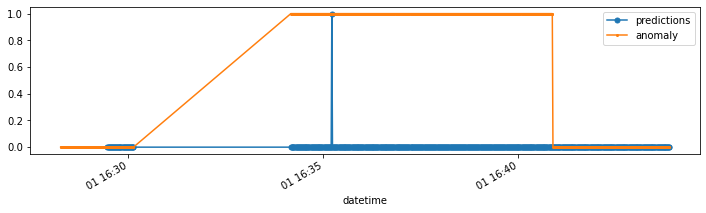

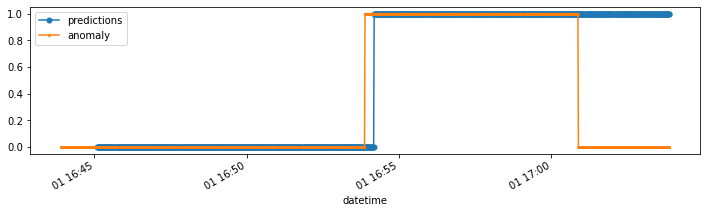

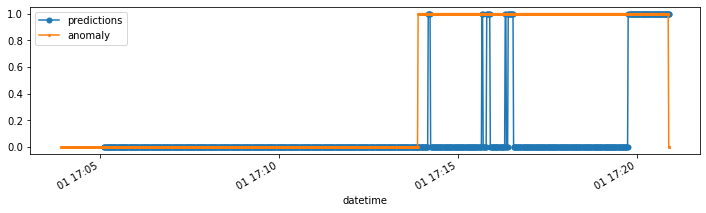

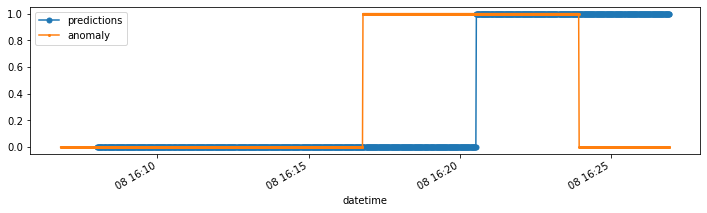

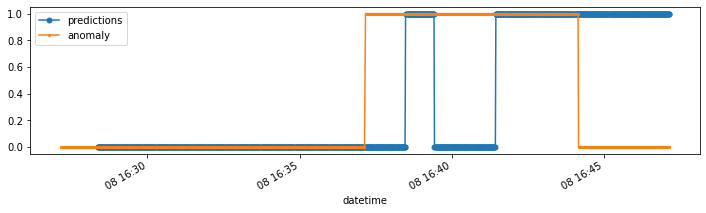

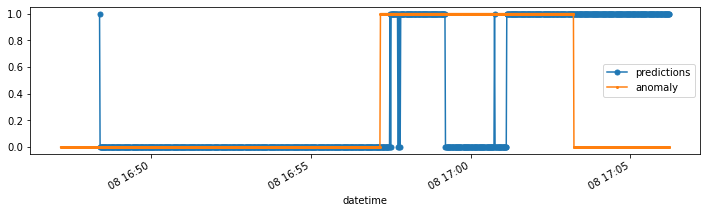

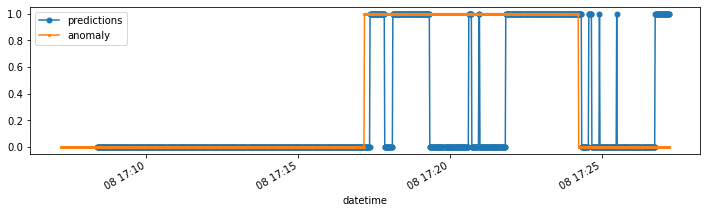

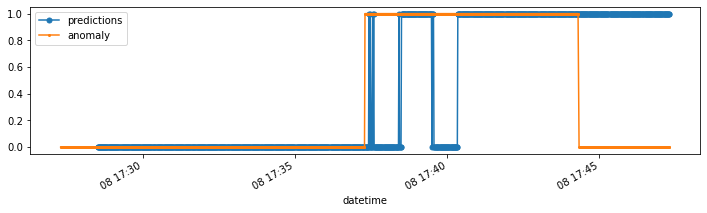

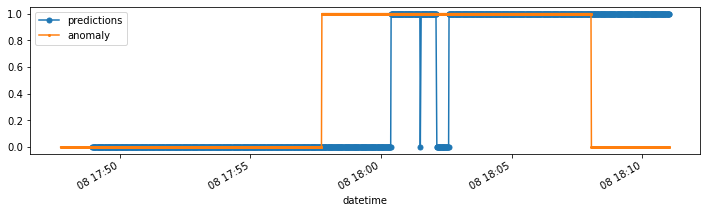

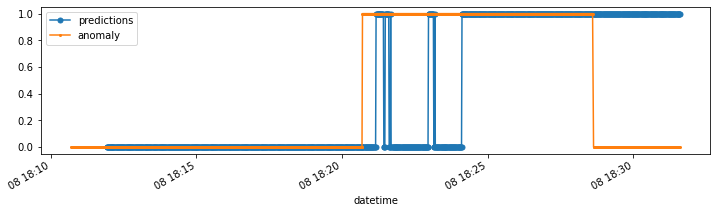

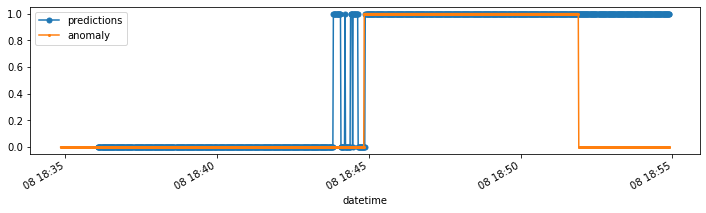

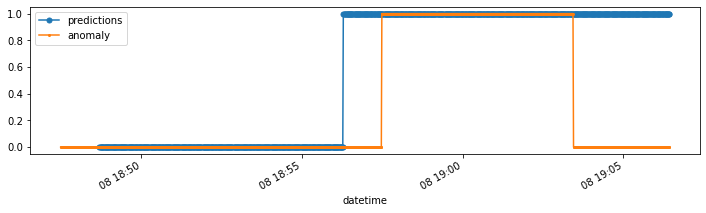

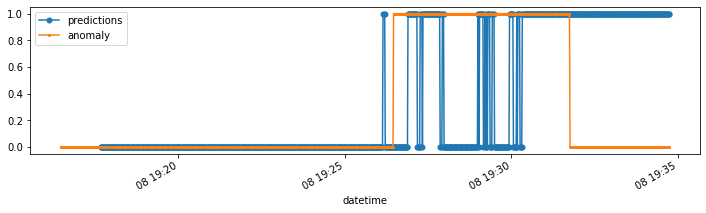

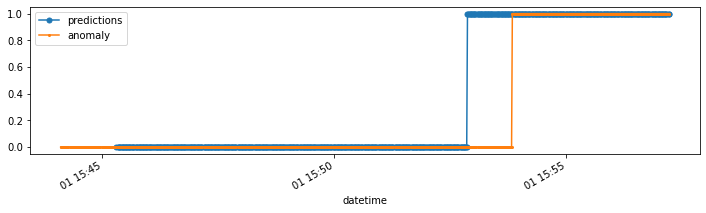

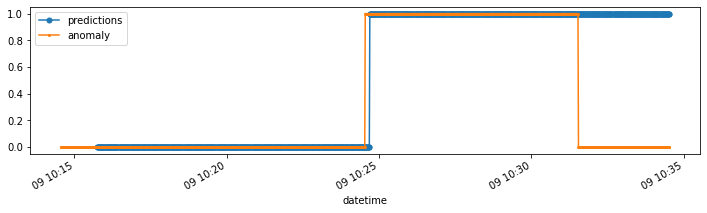

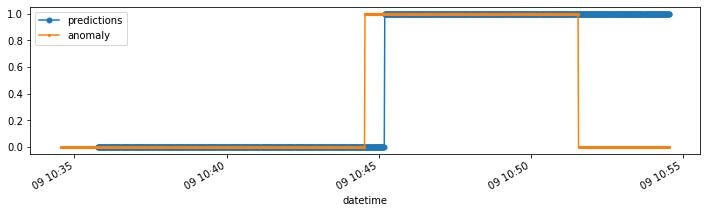

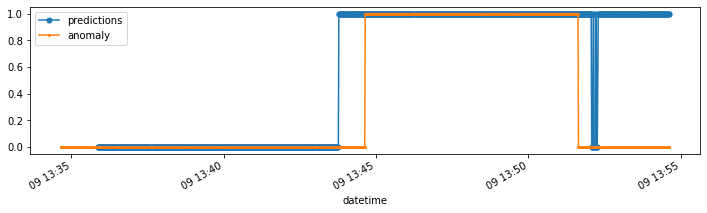

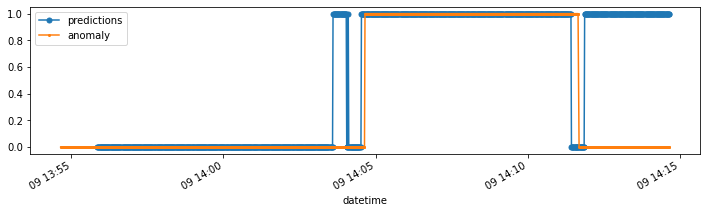

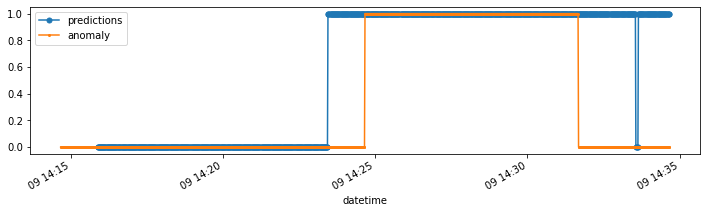

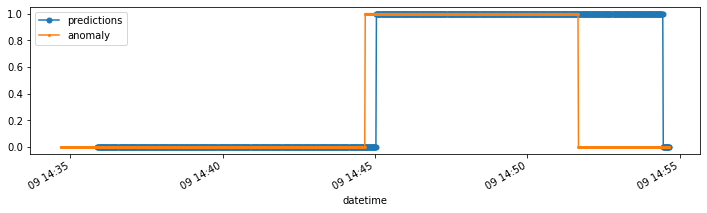

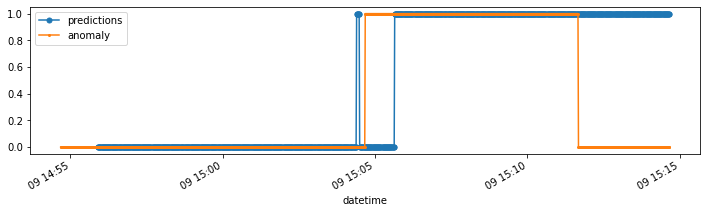

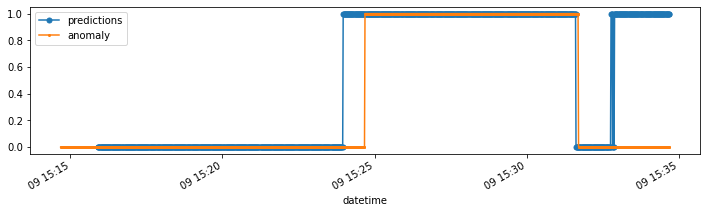

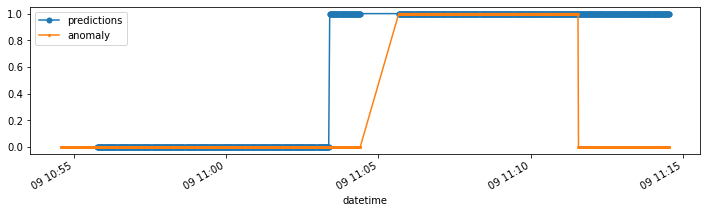

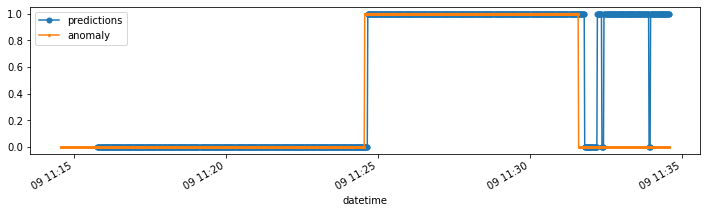

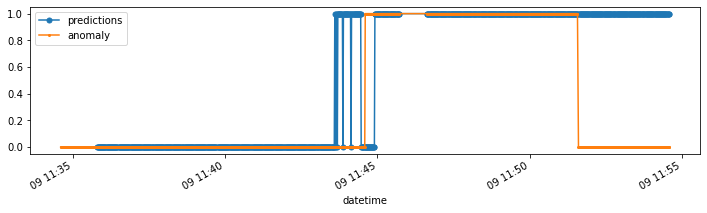

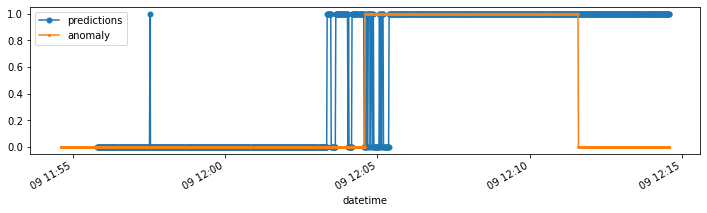

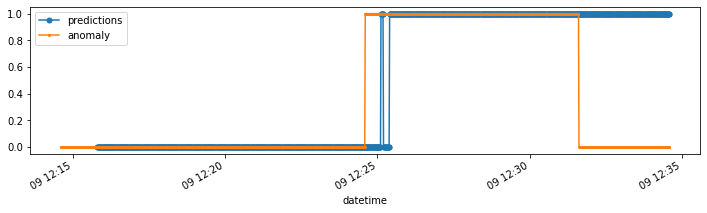

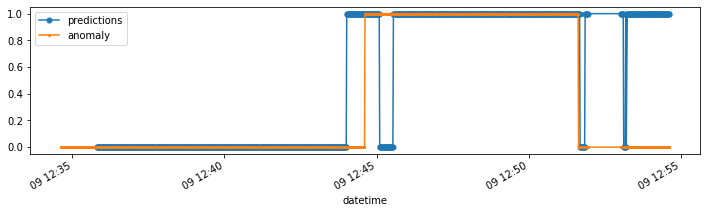

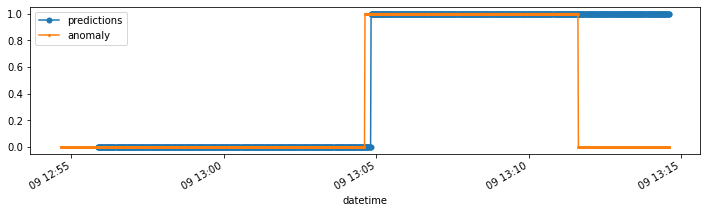

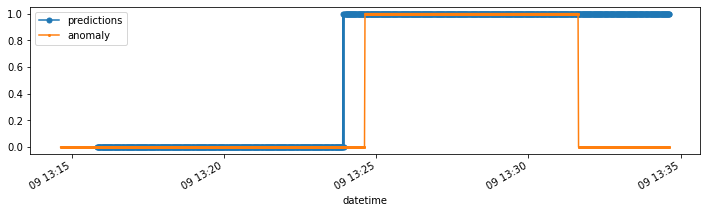

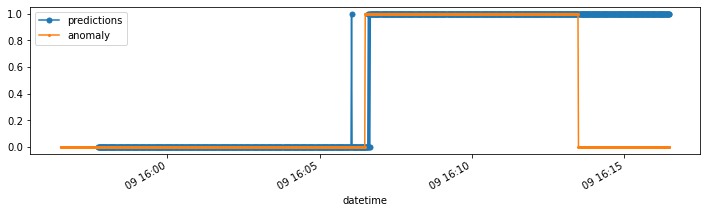

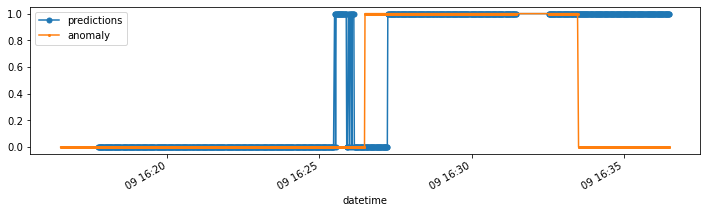

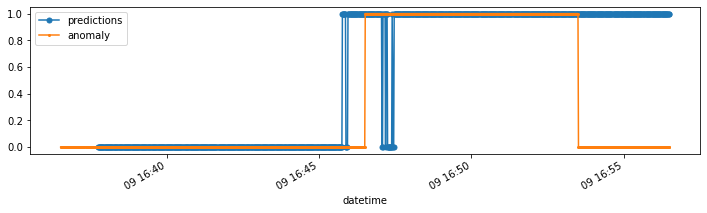

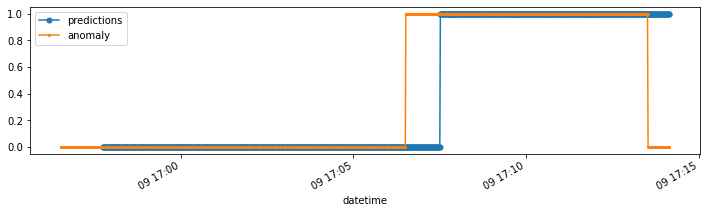

In [28]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

for i in range(len(predicted_outlier)):
    plt.figure(figsize=(12,3))
    predicted_outlier[i].plot(label='predictions', marker='o', markersize=5)
    true_outlier[i].plot(marker='o', markersize=2)
    plt.legend();

<ipython-input-29-54b0d7bed347>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,3))


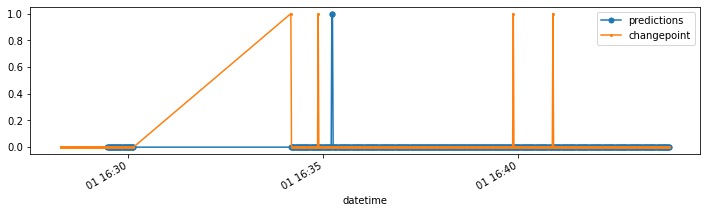

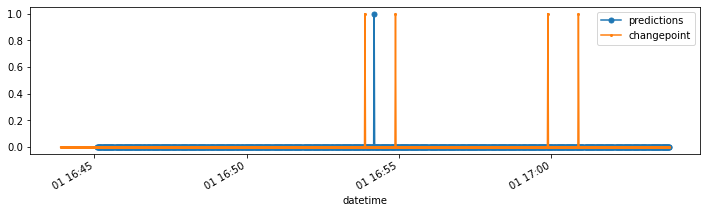

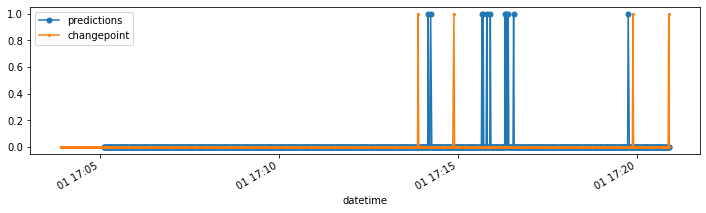

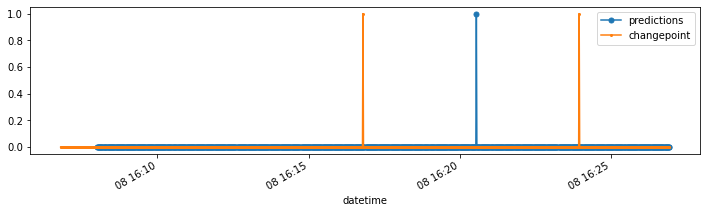

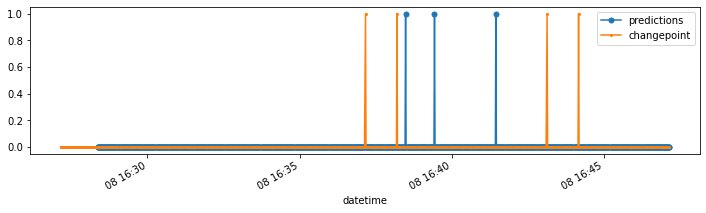

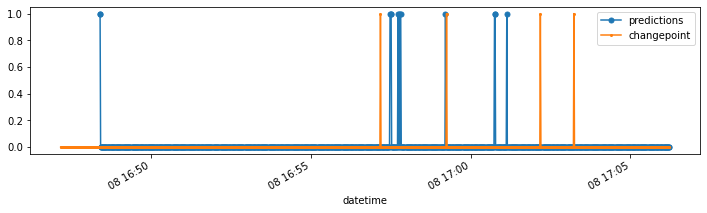

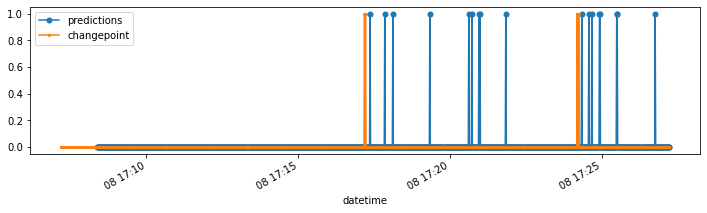

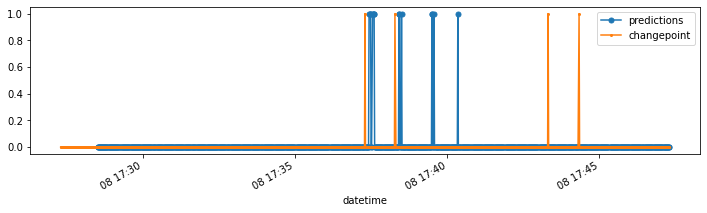

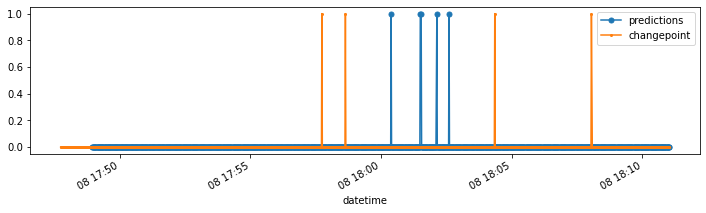

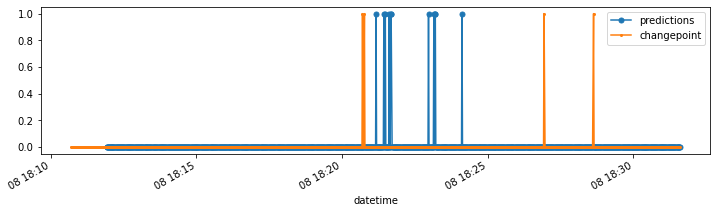

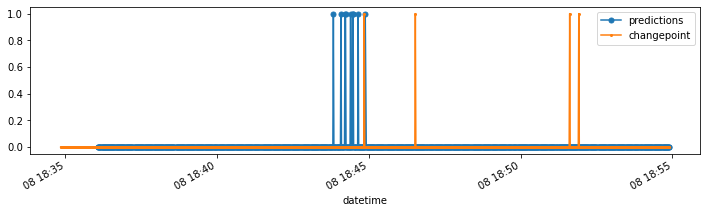

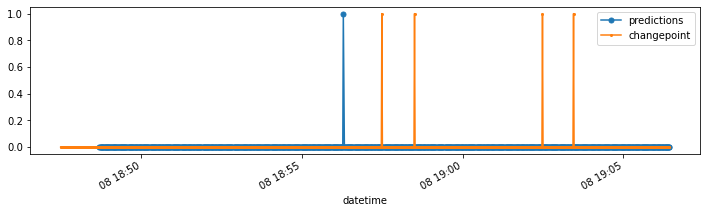

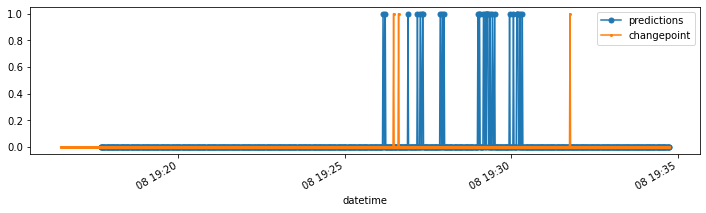

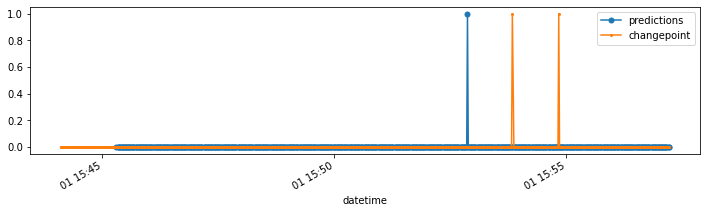

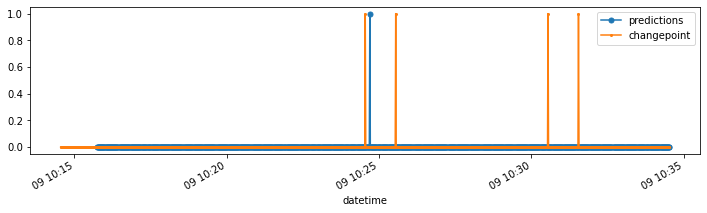

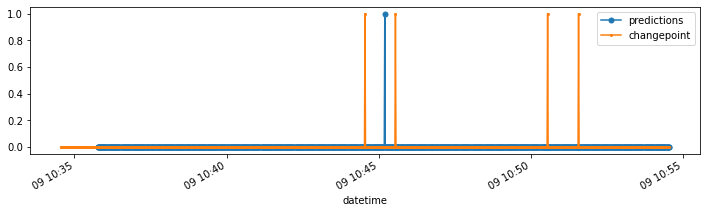

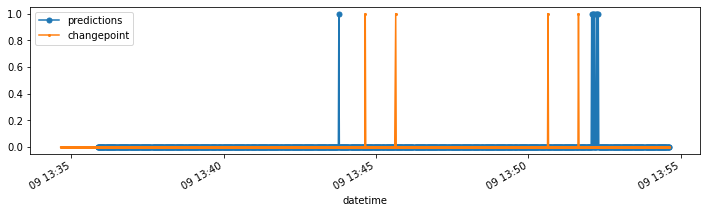

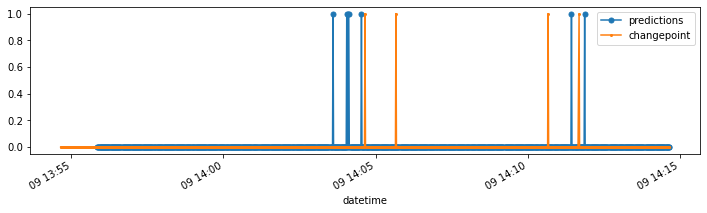

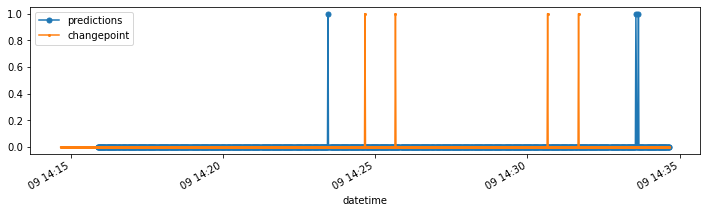

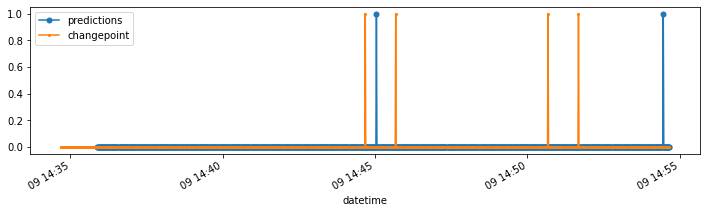

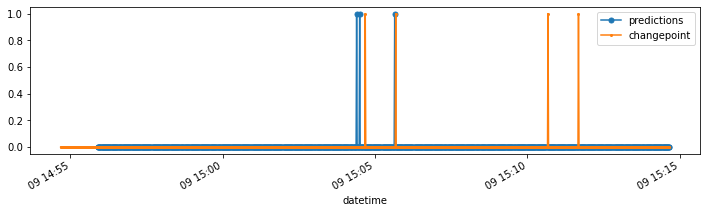

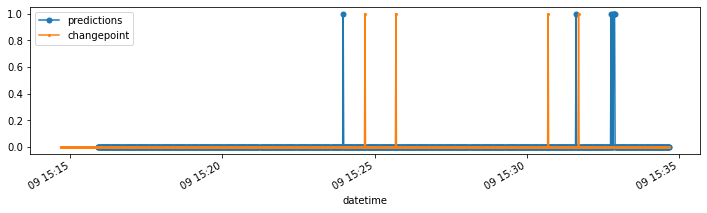

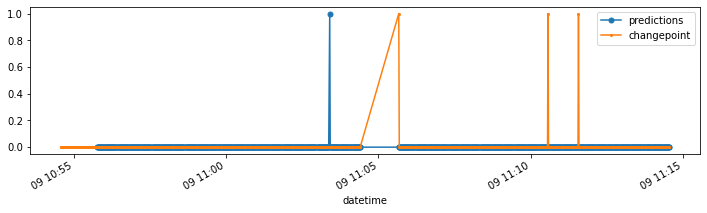

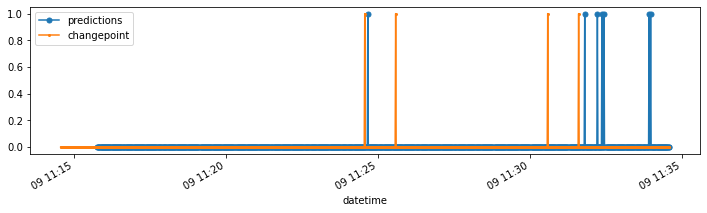

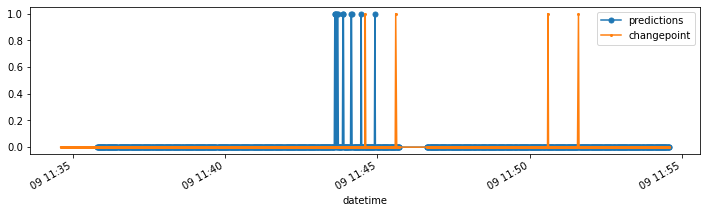

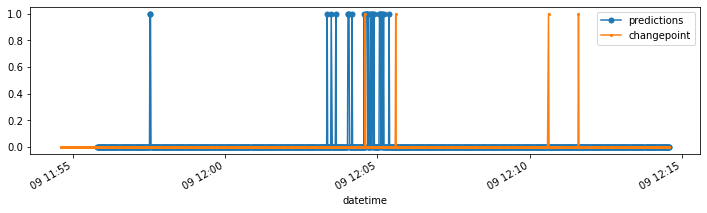

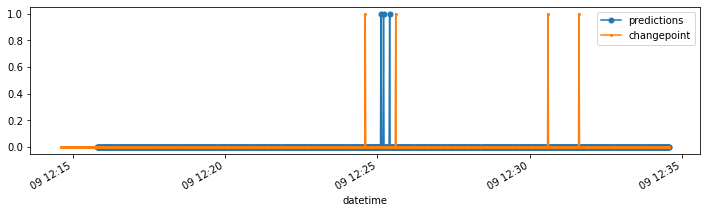

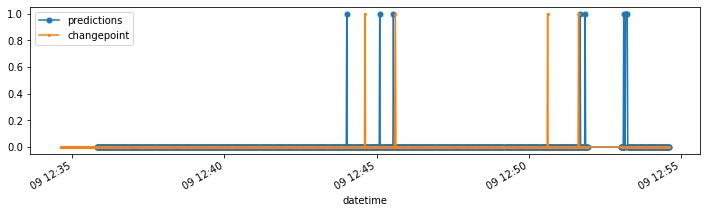

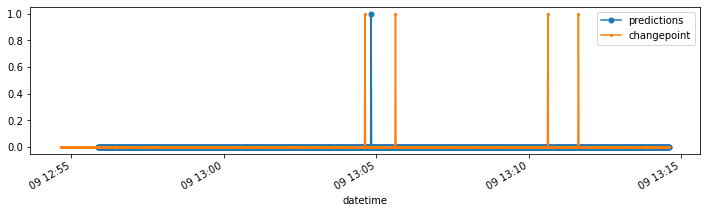

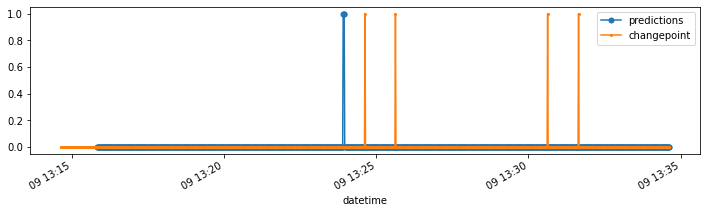

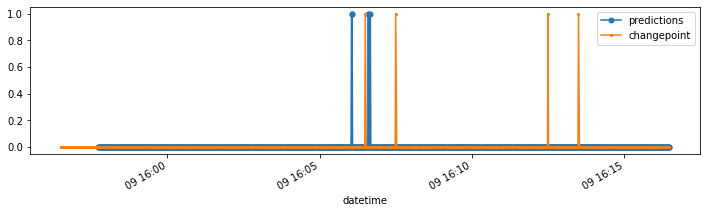

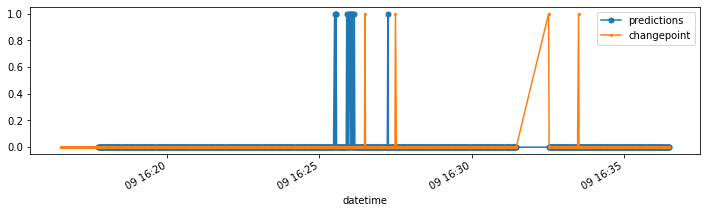

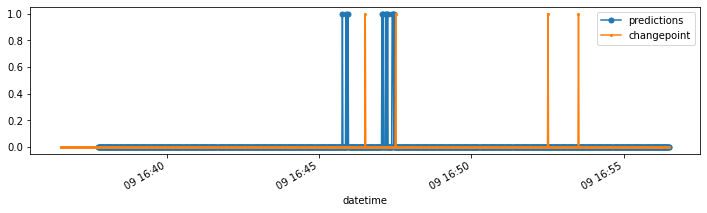

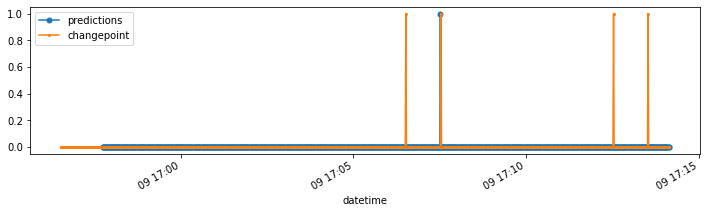

In [29]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

for i in range(len(predicted_cp)):
    plt.figure(figsize=(12,3))
    predicted_cp[i].plot(label='predictions', marker='o', markersize=5)
    true_cp[i].plot(marker='o', markersize=2)
    plt.legend();

## Metrics calculation

In [30]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier, predicted_outlier, metric='binary', numenta_time='30 sec')

False Alarm Rate 25.17 %
Missing Alarm Rate 18.03 %


In [31]:
# average detection delay metric calculation
add = evaluating_change_point(true_cp, predicted_cp, metric='average_delay', numenta_time='30 sec')

Average delay 0 days 00:00:14.107142857
A number of missed CPs = 102


In [32]:
# nab metric calculation
nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')

Intersection of the windows of too wide widths for dataset 2
Intersection of the windows of too wide widths for dataset 2
Intersection of the windows of too wide widths for dataset 2
Intersection of the windows of too wide widths for dataset 6
Intersection of the windows of too wide widths for dataset 6
Intersection of the windows of too wide widths for dataset 6
Intersection of the windows of too wide widths for dataset 6
Intersection of the windows of too wide widths for dataset 6
Intersection of the windows of too wide widths for dataset 6
Intersection of the windows of too wide widths for dataset 9
Intersection of the windows of too wide widths for dataset 9
Intersection of the windows of too wide widths for dataset 9
Intersection of the windows of too wide widths for dataset 10
Intersection of the windows of too wide widths for dataset 10
Intersection of the windows of too wide widths for dataset 10
Intersection of the windows of too wide widths for dataset 12
Intersection of the 